<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/lab_solutions/lab03_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from PIL import Image

Download an image

In [3]:
!wget -q -O logo.jpeg 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSixRrWNbEVXhVaaYYUQhbWpCa3KbxI65ZoXw&s'

Image is 165 x 225 pixels


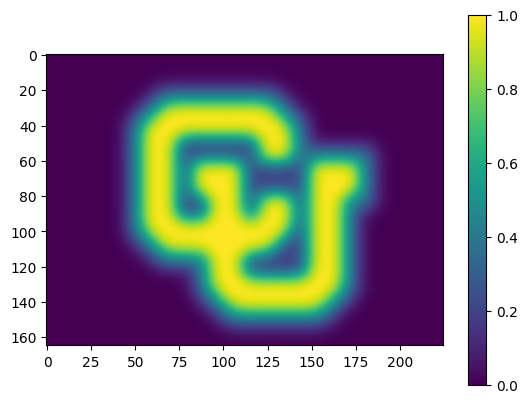

In [4]:
im = Image.open("logo.jpeg")
# print(im.format, im.size, im.mode)
n1,n2 = im.size
# im.show() # or just im  by itself
image = np.array(
    im.convert('L').getdata(), # turns it to grayscale
    dtype=np.float32  # convert to floating point, and use Single not Double since that's default for PyTorch
    ).reshape(im.size[0], im.size[1])

# For the CU logo, let's take just the central part:
image = image[:-60,:]

# and to make it even easier, let's make the image smooth
image = gaussian_filter(image,sigma=5)

image /= image.max() # put it in [0,1] range, so neural net initialization works
n1,n2 = image.shape
print(f'Image is {n1} x {n2} pixels')
plt.imshow( image )
plt.colorbar()
plt.show()

In [5]:
def trueLabels(X):
  """ Assumes 2D input, typically in [0,1] x [0,1]
  X has size [batch,2]
  Internally, converts the 2D coordinates to 1D indices
    then changes from a continuous value to a discrete value and returns the value of that pixel
  """
  X = np.ravel_multi_index( (np.int64(X[:,0]*n1), np.int64(X[:,1]*n2)), mode='clip', dims=(n1,n2) )
  y = np.ravel(image)[X]
  return torch.from_numpy(y ).unsqueeze(1) # unqueeze makes it size (batch_size,1) rather than (batch_size,)

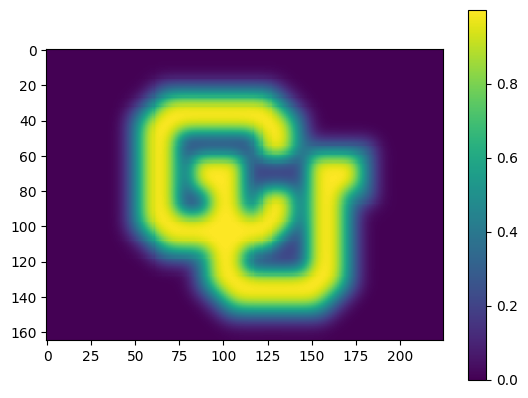

In [6]:
X = torch.cartesian_prod(torch.arange(0,n1)/n1,torch.arange(0,n2)/n2)
y = trueLabels(X)
plt.imshow(y.detach().numpy().reshape( (n1,n2) ) )
plt.colorbar()
plt.show()

In [10]:
loss_fn  = nn.MSELoss()
inputDim = 2
width1 = 10
width2 = 30
width3 = 50
width4 = 30
width5 = 10
outputDim  = 1
activation = nn.ReLU()
# activation = nn.GELU() # less stable! but might work better in the end

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential( nn.Linear(inputDim,width1),
          activation,   nn.Linear(width1,width2),
          activation,   nn.Linear(width2,width3),
          activation,   nn.Linear(width3,width4),
          activation,   nn.Linear(width4,width5),
          activation,   nn.Linear(width5,1) )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [12]:
model = MyNet()
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f'Using {device} device')
# model.to(device)  # NOTE: GPU implementation is not working

# Train with L-BFGS optimizer using full batches (not minibatches)
#   so the only thing stochastic is the initialization
learning_rate = 1
epochs        = 100
optimizer     = torch.optim.LBFGS(model.parameters(),
                                  lr=learning_rate,
                                  history_size=20,
                                  max_iter=10, line_search_fn='strong_wolfe')
lossHistory = []
size = 256**2
batch_size = size
print('== Training via L-BFGS ==')
for t in range(epochs):
    model.train()
    for batch in range(int(size/batch_size)):
        def closure():
            optimizer.zero_grad()
            X = torch.cartesian_prod(torch.arange(0,n1)/n1,torch.arange(0,n2)/n2) #.to(device)
            y = trueLabels(X) #.to(device)

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            if loss.requires_grad:  # since during a linesearch we don't need this...
                loss.backward()
            lossHistory.append( loss.item() )
            return loss

        optimizer.step( closure )

    if t < 10 or (t+1) % 5 == 0 :
      print(f"Epoch {t+1:3d}, loss: {lossHistory[-1]:>7f}")

== Training via L-BFGS ==
Epoch   1, loss: 0.125421
Epoch   2, loss: 0.114817
Epoch   3, loss: 0.072803
Epoch   4, loss: 0.051564
Epoch   5, loss: 0.039746
Epoch   6, loss: 0.033850
Epoch   7, loss: 0.028771
Epoch   8, loss: 0.026120
Epoch   9, loss: 0.025570
Epoch  10, loss: 0.024937
Epoch  15, loss: 0.020742
Epoch  20, loss: 0.017422
Epoch  25, loss: 0.016726
Epoch  30, loss: 0.016250
Epoch  35, loss: 0.015837
Epoch  40, loss: 0.015476
Epoch  45, loss: 0.015276
Epoch  50, loss: 0.014386
Epoch  55, loss: 0.014057
Epoch  60, loss: 0.013951
Epoch  65, loss: 0.013755
Epoch  70, loss: 0.013575
Epoch  75, loss: 0.013492
Epoch  80, loss: 0.013425
Epoch  85, loss: 0.012457
Epoch  90, loss: 0.012200
Epoch  95, loss: 0.011949
Epoch 100, loss: 0.011805


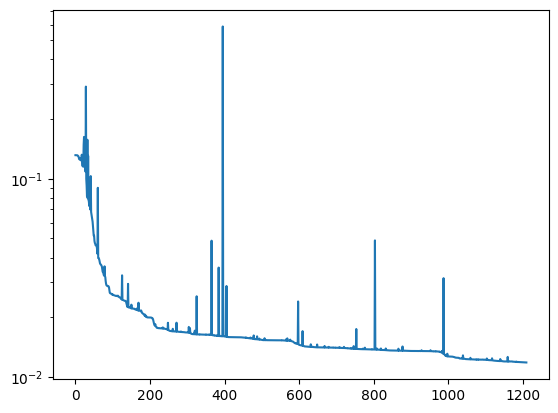

In [13]:
# plt.semilogy(gaussian_filter1d(lossHistory[:],sigma=50)) # smooth it a bit... Lightning will do this for you!
plt.semilogy( lossHistory )
plt.show()

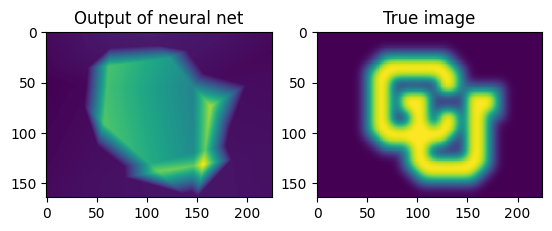

In [14]:
X    = torch.cartesian_prod(torch.arange(0,n1)/n1,torch.arange(0,n2)/n2)
y    = trueLabels(X)

model.eval()
with torch.no_grad():
    yHat = model(X)

fig, ax = plt.subplots(1,2)
ax[0].imshow(yHat.detach().numpy().reshape( (n1,n2) ) )
ax[0].set_title('Output of neural net')
ax[1].imshow(y.detach().numpy().reshape( (n1,n2) ) )
ax[1].set_title('True image')
plt.show()

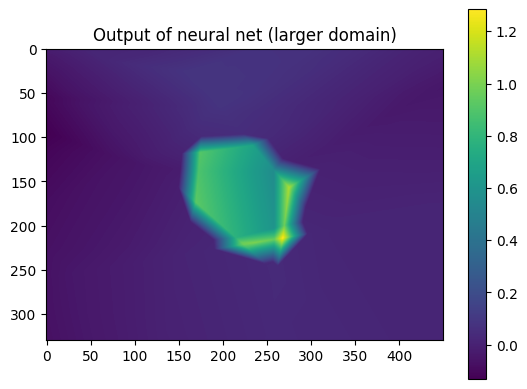

In [15]:
# For fun, we can see what our model predicts *outside* of [0,1] x [0,1]
# N1, N2 = n1, n2
# a, b   = 0, 1
N1, N2 = 2*n1, 2*n2
a, b   = -.5, 1.5
X    = torch.cartesian_prod(torch.linspace(a,b,steps=N1),torch.linspace(a,b,steps=N2) )

model.eval()
with torch.no_grad():
    yHat = model(X)

plt.imshow(yHat.detach().numpy().reshape( (N1,N2) ) )
plt.colorbar()
plt.title('Output of neural net (larger domain)')
plt.show()

### Train with a different optimizer

In [20]:
model = MyNet()

learning_rate = 1e-3
epochs        = 5
optimizer     = torch.optim.SGD(model.parameters(),
                                  lr=learning_rate)
lossHistory = []
size = 256**2
batch_size = 10
print('== Training via SGD ==')
for t in range(epochs):
    model.train()
    num_batches = int(size/batch_size)
    runningLoss = 0.
    for batch in range(num_batches):
        # sample in [0,1] x 0,1
        X = torch.cartesian_prod(torch.randn(batch_size),torch.randn(batch_size)) #.to(device)
        y = trueLabels(X) #.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()

        runningLoss += loss.item()



        optimizer.step()
        optimizer.zero_grad()
    lossHistory.append( runningLoss/num_batches )
    if t < 10 or (t+1) % 5 == 0 :
      print(f"Epoch {t+1:3d}, loss: {lossHistory[-1]:>7f}")

== Training via SGD ==
Epoch   1, loss: 0.024646
Epoch   2, loss: 0.023851
Epoch   3, loss: 0.023209
Epoch   4, loss: 0.023166
Epoch   5, loss: 0.022541


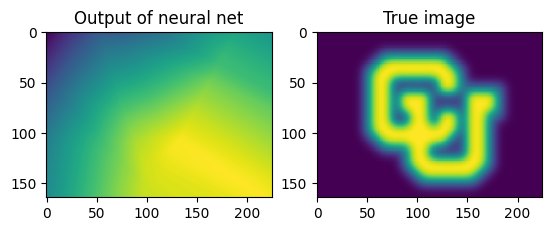

In [21]:
X    = torch.cartesian_prod(torch.arange(0,n1)/n1,torch.arange(0,n2)/n2)
y    = trueLabels(X)

model.eval()
with torch.no_grad():
    yHat = model(X)

fig, ax = plt.subplots(1,2)
ax[0].imshow(yHat.detach().numpy().reshape( (n1,n2) ) )
ax[0].set_title('Output of neural net')
ax[1].imshow(y.detach().numpy().reshape( (n1,n2) ) )
ax[1].set_title('True image')
plt.show()